In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [3]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [4]:
def smoothen(df, columns=[], N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_avg_df = df.copy().reset_index(drop=True)
    # An N-day rolling average with N/2 days before and N/2 after requires N+1
    # days to include the day of as well.
    rolling_avg_df[columns] = (
        rolling_avg_df[columns].rolling(N + 1, center=True).mean())
    return rolling_avg_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

In [5]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df[home_weekly_df['date_range_start'].dt.year.isin([2019, 2020])]
home_weekly_df = home_weekly_df.rename(columns={'home_weekly_cbg': 'cbg'})
home_weekly_df.head()

placekey          date_range_start      home_cbg  \
95  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360050001000   
96  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470206001   
97  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470435003   
98  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470437001   
99  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470573002   

    visitor_count  estimated_visitor_count  pct_visitor_count  \
95              4                 0.000000           0.333333   
96              4                 9.790000           0.021739   
97              4                 8.605042           0.016129   
98              4                11.749526           0.024390   
99              5                 1.068101           0.005160   

    pct_estimated_visitor_count       cdi  
95                     0.000000  0.000000  
96                     0.021739  2.772665  
97                     0.016129  2.437068  
98                     0.024390  3.327630  
99                     0.005160  0.302501

In [6]:
POI_TYPES = ['ffr', 'fvm', 'sm', 'deli', 'fsr', 'lsr']
POI_TITLES = ['FFRs', 'FVMs', 'Supermarkets', 'Delis', 'FSRs', 'LSRs']

In [7]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
poi_cat_df = poi_df
poi_cat_df['is_ffr'] = (poi_cat_df['category'] == 'Fast-Food Restaurants')
poi_cat_df['is_fvm'] = (poi_cat_df['sub_category'] == 'Fruit and Vegetable Markets')
poi_cat_df['is_sm'] = (poi_cat_df['category'] == 'Supermarkets')
poi_cat_df['is_fsr'] = (poi_cat_df['category'] == 'Full-Service Restaurants')
poi_cat_df['is_lsr'] = (poi_cat_df['category'] == 'Limited-Service Restaurants')
poi_cat_df['is_deli'] = (poi_cat_df['category'] == 'Delis and Convenience Stores')

poi_cat_df = poi_cat_df[['placekey'] + [f'is_{t}' for t in POI_TYPES]]
peek(poi_cat_df)

placekey  is_ffr  is_fvm  is_sm  is_deli  is_fsr  is_lsr
0  226-222@627-s4n-pqf   False   False  False    False   False   False
1  225-225@627-s99-9xq   False   False  False    False   False   False
2  225-225@627-vsw-7nq   False   False  False    False   False   False

36467


In [8]:
home_df = home_weekly_df.merge(poi_cat_df, on=['placekey'], how='inner')
home_df = home_df.rename(columns={'home_cbg': 'cbg'})

for poi_type in POI_TYPES:
    home_df[f'estimated_{poi_type}_visitor_count'] = 0
    home_df.loc[home_df[f'is_{poi_type}'],
                f'estimated_{poi_type}_visitor_count'] = home_df['estimated_visitor_count']
peek(home_df)

placekey          date_range_start           cbg  visitor_count  \
0  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360050001000              4   
1  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470206001              4   
2  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470435003              4   

   estimated_visitor_count  pct_visitor_count  pct_estimated_visitor_count  \
0                 0.000000           0.333333                     0.000000   
1                 9.790000           0.021739                     0.021739   
2                 8.605042           0.016129                     0.016129   

        cdi  is_ffr  is_fvm  is_sm  is_deli  is_fsr  is_lsr  \
0  0.000000   False   False  False    False    True   False   
1  2.772665   False   False  False    False    True   False   
2  2.437068   False   False  False    False    True   False   

   estimated_ffr_visitor_count  estimated_fvm_visitor_count  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   

   estimated_sm_visitor_count  estimated_deli_visitor_count  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   

   estimated_fsr_visitor_count  estimated_lsr_visitor_count  
0                     0.000000                          0.0  
1                     9.790000                          0.0  
2                     8.605042                          0.0

26675352


In [9]:
cbg_gdf = gpd.read_file('./data/nyc_cbgs.geojson')
cbg_gdf = cbg_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_gdf['cbg'] = cbg_gdf['cbg'].astype(int)
cbg_gdf = cbg_gdf[['cbg', 'geometry']]

#cbg_gdf = cbg_gdf.merge(
#    proximity_df[['cbg', 'near_ffr', 'near_ssfs', 'near_ffr_only', 'near_ssfs_only']],
#    on=['cbg'],
#    how='inner')
#
#cbg_gdf['color_ffr'] = 'C' + cbg_gdf['near_ffr'].astype(int).astype(str)
#cbg_gdf['color_ssfs'] = 'C' + cbg_gdf['near_ssfs'].astype(int).astype(str)
#cbg_gdf['color_ffr_only'] = 'C' + cbg_gdf['near_ffr_only'].astype(int).astype(str)
#cbg_gdf['color_ssfs_only'] = 'C' + cbg_gdf['near_ssfs_only'].astype(int).astype(str)

cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Median Household Income': 'income',
    'Total Population': 'population',
    'Percent Households with one or more people under 18 years': 'pct_children',
    'Percent Household received Food Stamps/SNAP': 'pct_snap',
    'Percent Households Income in the past 12 months below poverty level': 'pct_poverty',
})
cbg_df = cbg_df[['cbg', 'population', 'income', 'pct_children', 'pct_snap', 'pct_poverty']]

cbg_gdf = cbg_gdf.merge(cbg_df, on=['cbg'], how='inner')
cbg_gdf['area'] = cbg_gdf['geometry'].area * 1000 * 1000

# XXX: Areas are already population-dependent.
cbg_gdf['population_density'] = cbg_gdf['population'] / cbg_gdf['area']
peek(cbg_gdf)

cbg                                           geometry  \
0  360050175002  MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ...   
1  360050141001  MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ...   
2  360050145001  MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ...   

   population   income  pct_children  pct_snap  pct_poverty      area  \
0         656  24091.0      0.086592  0.597765     0.460894  2.529399   
1        1228  18472.0      0.379722  0.578529     0.590457  5.970710   
2        2716  37628.0      0.501029  0.549383     0.354938  5.020312   

   population_density  
0          259.350197  
1          205.670682  
2          541.002233

6221


In [10]:
merge_df = home_df.merge(cbg_df, how='inner', on=['cbg'])
peek(merge_df)

placekey          date_range_start           cbg  visitor_count  \
0  22t-222@627-s7m-rtv 2019-01-07 00:00:00-05:00  360470206001              4   
1  22j-222@627-wgt-gff 2019-01-28 00:00:00-05:00  360470206001              4   
2  zzw-222@627-vs9-grk 2019-02-04 00:00:00-05:00  360470206001              4   

   estimated_visitor_count  pct_visitor_count  pct_estimated_visitor_count  \
0                 9.790000           0.021739                     0.021739   
1                 9.669136           0.021622                     0.021622   
2                 9.368421           0.019048                     0.019048   

        cdi  is_ffr  is_fvm  ...  estimated_fvm_visitor_count  \
0  2.772665   False   False  ...                          0.0   
1  2.216524   False   False  ...                          0.0   
2  0.583973   False   False  ...                          0.0   

   estimated_sm_visitor_count  estimated_deli_visitor_count  \
0                    0.000000                           0.0   
1                    9.669136                           0.0   
2                    0.000000                           0.0   

   estimated_fsr_visitor_count  estimated_lsr_visitor_count  population  \
0                     9.790000                          0.0         979   
1                     0.000000                          0.0         979   
2                     9.368421                          0.0         979   

    income  pct_children  pct_snap  pct_poverty  
0  99028.0      0.176755  0.171913       0.1477  
1  99028.0      0.176755  0.171913       0.1477  
2  99028.0      0.176755  0.171913       0.1477  

[3 rows x 25 columns]

26592552


In [11]:
merge_df.columns

Index(['placekey', 'date_range_start', 'cbg', 'visitor_count',
       'estimated_visitor_count', 'pct_visitor_count',
       'pct_estimated_visitor_count', 'cdi', 'is_ffr', 'is_fvm', 'is_sm',
       'is_deli', 'is_fsr', 'is_lsr', 'estimated_ffr_visitor_count',
       'estimated_fvm_visitor_count', 'estimated_sm_visitor_count',
       'estimated_deli_visitor_count', 'estimated_fsr_visitor_count',
       'estimated_lsr_visitor_count', 'population', 'income', 'pct_children',
       'pct_snap', 'pct_poverty'],
      dtype='object')

In [12]:
def create_diff_df(metric_df, diff_columns=[], keep_columns=[]):
    metric_week_df = metric_df
    metric_week_df['year'] = metric_week_df['date_range_start'].dt.year
    metric_week_df['week'] = metric_week_df['date_range_start'].dt.week

    # Dates are missing from December 2020!

    metric_2020_df = metric_week_df[metric_week_df['year'] == 2020]
    metric_2020_df = metric_2020_df[metric_2020_df['week'] >= 2]
    metric_2020_df = metric_2020_df[metric_2020_df['week'] <= 52].reset_index(
        drop=True)
    metric_2019_df = metric_week_df[metric_week_df['year'] == 2019]
    metric_2019_df = metric_2019_df[metric_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    metric_2019_df = metric_2019_df[~metric_2019_df['week'].isin(set([50, 51]))]
    metric_2019_df = metric_2019_df[metric_2019_df['week'] <= 52].reset_index(
        drop=True)

    metric_diff_df = pd.DataFrame()
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        metric_diff_df[keep_column] = metric_2020_df[keep_column]
    metric_diff_df[diff_columns] = (metric_2020_df[diff_columns] -
                                    metric_2019_df[diff_columns])
    metric_diff_df = metric_diff_df.dropna()

    peek(metric_diff_df.head())

    return metric_diff_df

In [13]:
def create_boolean_dfs(df, poi_types=POI_TYPES, attr_column=''):
    merge_boolean_df = merge_df.merge(cbg_gdf[['cbg', attr_column]], how='inner', on=['cbg'])
    agg = {f'estimated_{t}_visitor_count': 'sum' for t in poi_types}
    agg['estimated_visitor_count'] = 'sum'
    
    boolean_df = merge_boolean_df.groupby(
        by=['date_range_start', attr_column]).agg(agg).reset_index()
    for poi_type in poi_types:
        boolean_df[f'pct_{poi_type}'] = (
            boolean_df[f'estimated_{poi_type}_visitor_count'] /
            boolean_df['estimated_visitor_count'])
    pct_columns = [f'pct_{t}' for t in poi_types] 
    boolean_diff_df = create_diff_df(boolean_df,
                                      diff_columns=pct_columns,
                                      keep_columns=[attr_column])
    boolean_df = smoothen_within(boolean_df, columns=pct_columns, by=attr_column)
    boolean_diff_df = smoothen_within(boolean_diff_df,
                                       columns=pct_columns,
                                       by=attr_column)
    return (boolean_df, boolean_diff_df)

In [14]:
def plot_boolean_dfs(df, diff_df, gdf, poi_types=POI_TYPES, poi_titles=POI_TITLES, attr_column='', attr_title=''):
    for i, poi_type in enumerate(poi_types):
        fig, ax = plt.subplots(1, 3, figsize=(21, 7))

        gdf.plot(ax=ax[0], color=gdf[f'color_{attr_column}'])
        ax[0].set_title(f'Top 50% {attr_title}')

        for key, group in df.groupby(by=[attr_column]):
            ax[1].plot(group['date_range_start'], group[f'pct_{poi_type}'], label=key)
        ax[1].set_title(f'% of Trips to {poi_titles[i]} (Top 50% {attr_title})')

        for key, group in diff_df.groupby(by=[attr_column]):
            ax[2].plot(group['date_range_start'], group[f'pct_{poi_type}'], label=key)
        ax[2].set_title(f'Diff % of Trips to {poi_titles[i]} (Top 50% {attr_title})')

        ax[1].legend()
        ax[2].legend()

        ax[1].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
        ax[2].axvline(datetime.datetime(2020, 3, 20), linestyle='--')

        plt.tight_layout()
        plt.show()

## Population Density

is_dense  week          date_range_start   pct_ffr   pct_fvm    pct_sm  \
0     False     2 2020-01-06 00:00:00-05:00  0.005661  0.000252  0.002192   
1      True     2 2020-01-06 00:00:00-05:00  0.006049 -0.000016  0.004242   
2     False     3 2020-01-13 00:00:00-05:00  0.004764 -0.000174  0.001083   

   pct_deli   pct_fsr   pct_lsr  
0 -0.003116 -0.006730 -0.001833  
1 -0.003123  0.000334 -0.002716  
2 -0.005574  0.000075  0.001019

5


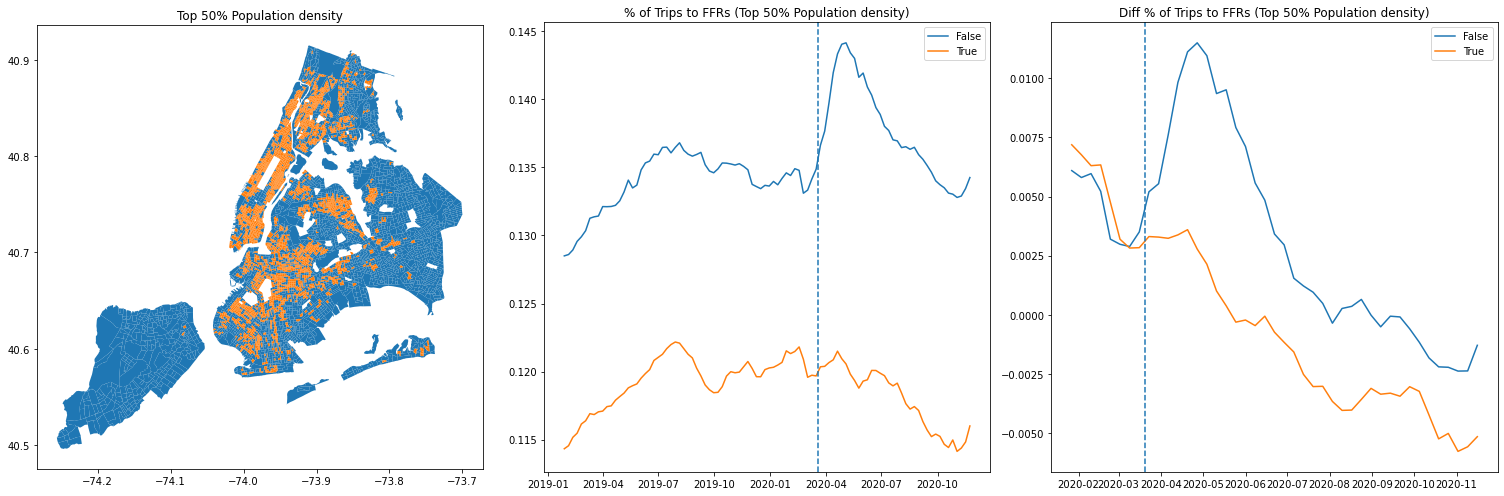

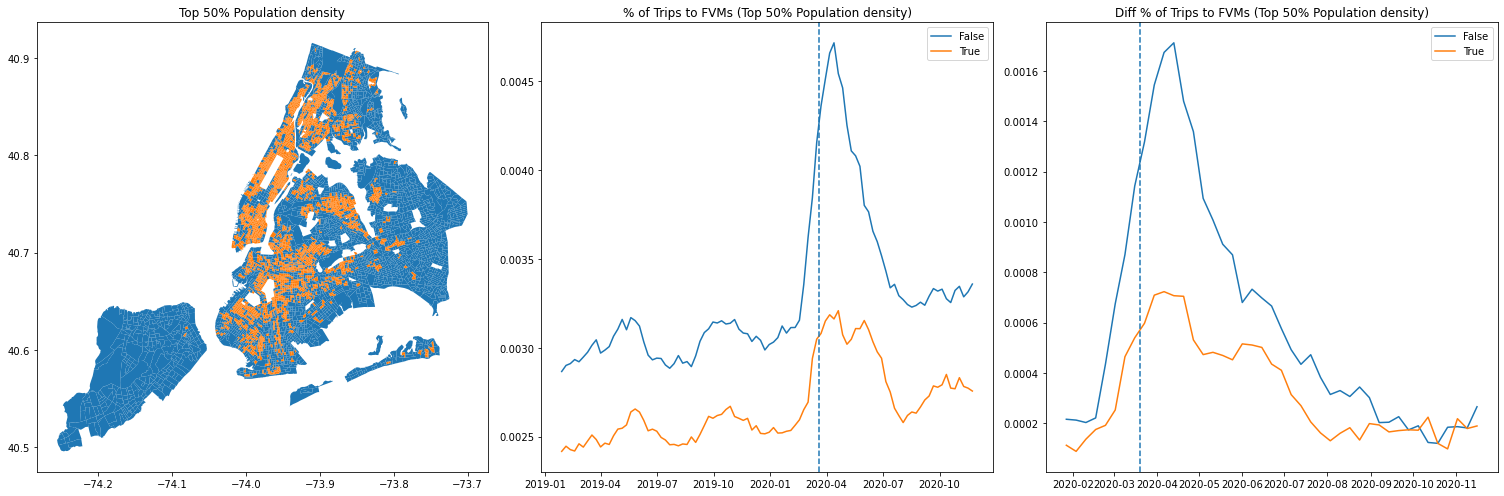

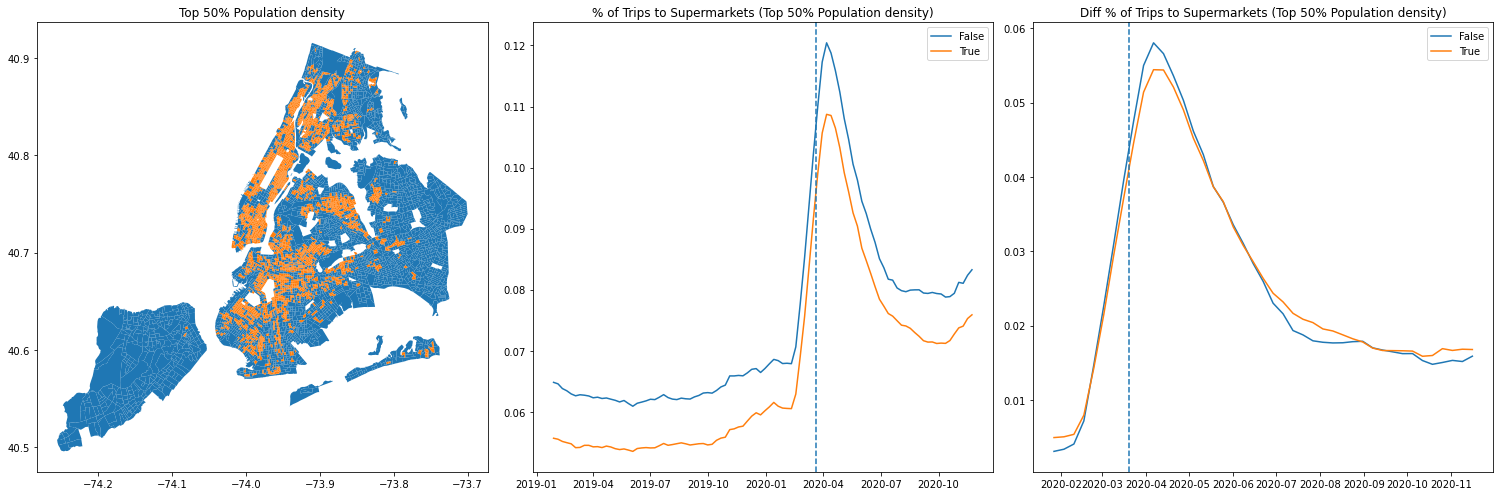

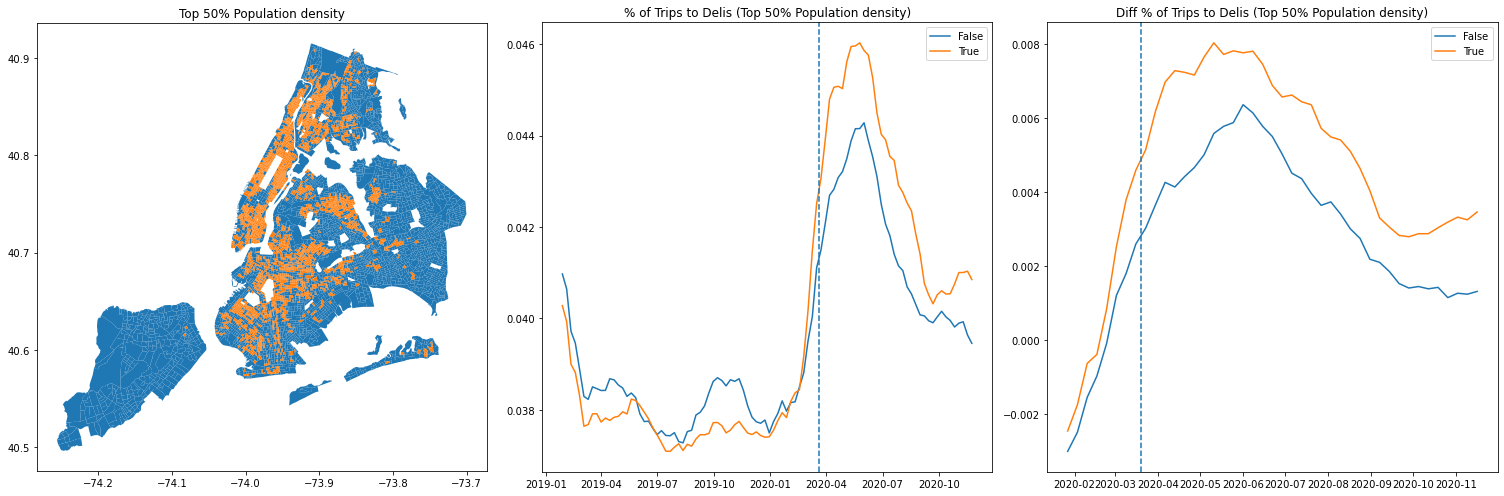

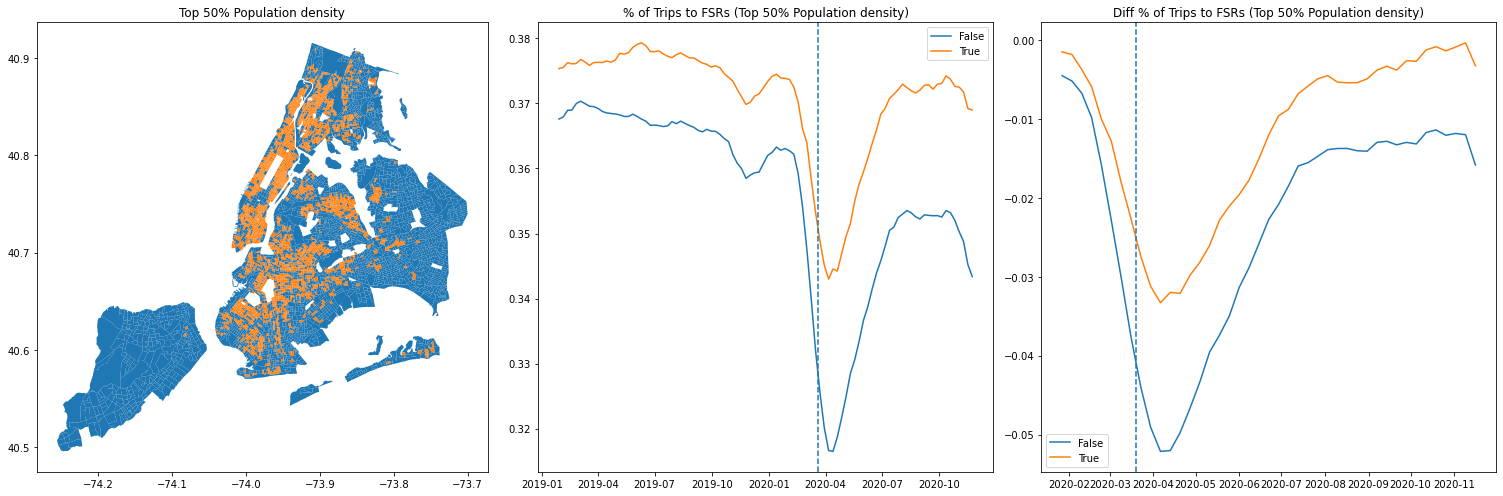

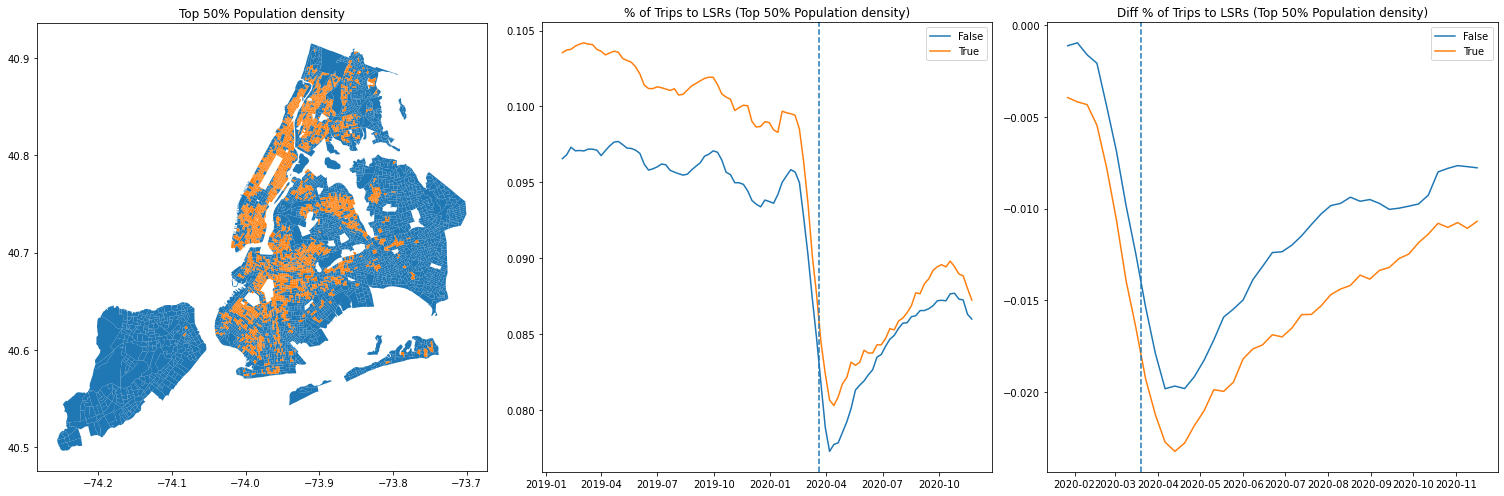

In [15]:
# XXX: Areas already population-based.
cbg_gdf['population_density'] = cbg_gdf['population'] / (cbg_gdf['geometry'].area * 1000 * 1000)
median_index = np.median(cbg_gdf['population_density'].dropna())

cbg_gdf['is_dense'] = cbg_gdf['population_density'] > median_index
cbg_gdf['color_is_dense'] = 'C' + cbg_gdf['is_dense'].astype(int).astype(str)

dense_df, dense_diff_df = create_boolean_dfs(cbg_gdf, poi_types=POI_TYPES, attr_column='is_dense')
plot_boolean_dfs(dense_df, dense_diff_df, cbg_gdf, poi_types=POI_TYPES, poi_titles=POI_TITLES, attr_column='is_dense', attr_title='Population density')

## Income

is_high_income  week          date_range_start   pct_ffr   pct_fvm  \
0           False     2 2020-01-06 00:00:00-05:00  0.007809  0.000006   
1            True     2 2020-01-06 00:00:00-05:00  0.003386  0.000199   
2           False     3 2020-01-13 00:00:00-05:00  0.010610 -0.000369   

     pct_sm  pct_deli   pct_fsr   pct_lsr  
0  0.003724 -0.005285 -0.003902 -0.001705  
1  0.001995 -0.001570 -0.001665 -0.001584  
2  0.003203 -0.008197  0.000294 -0.003039

5


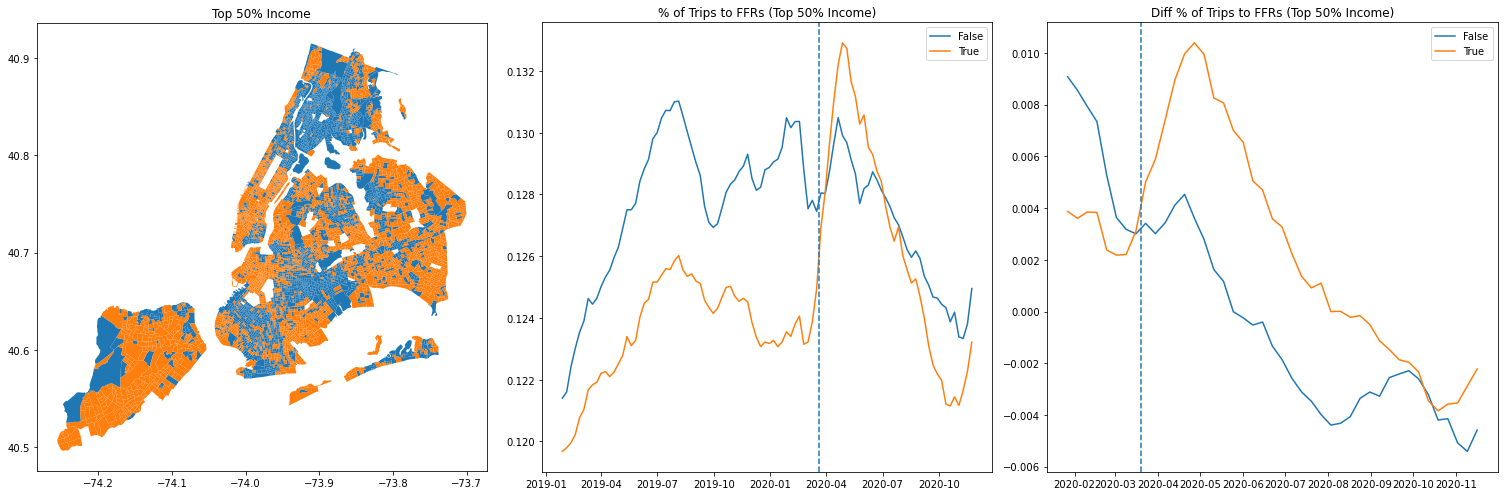

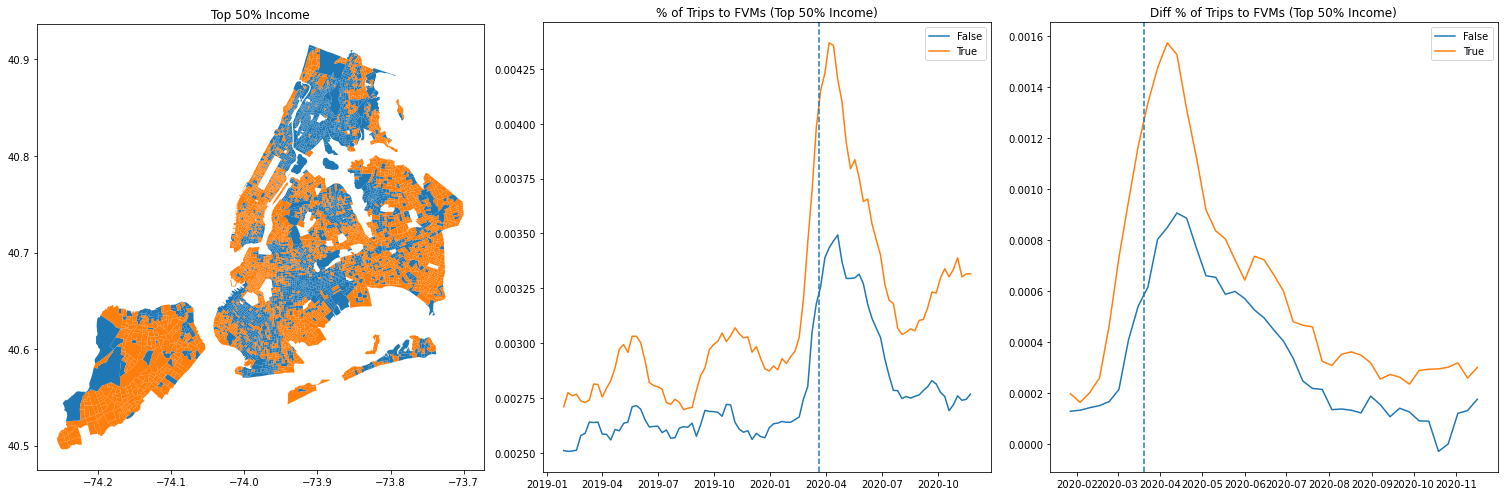

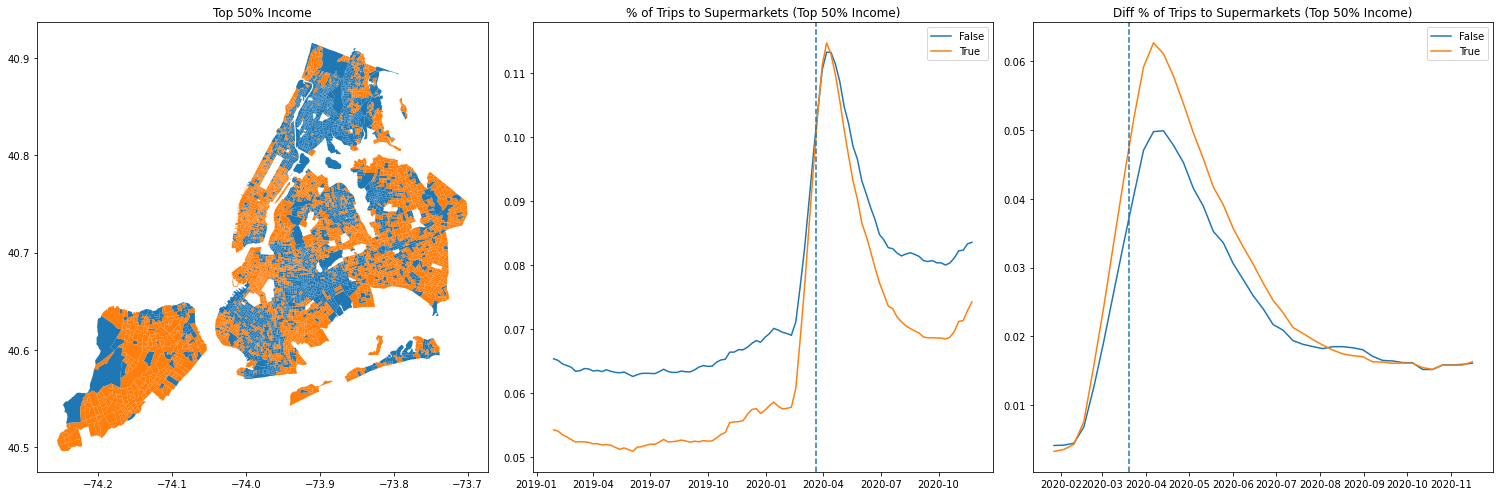

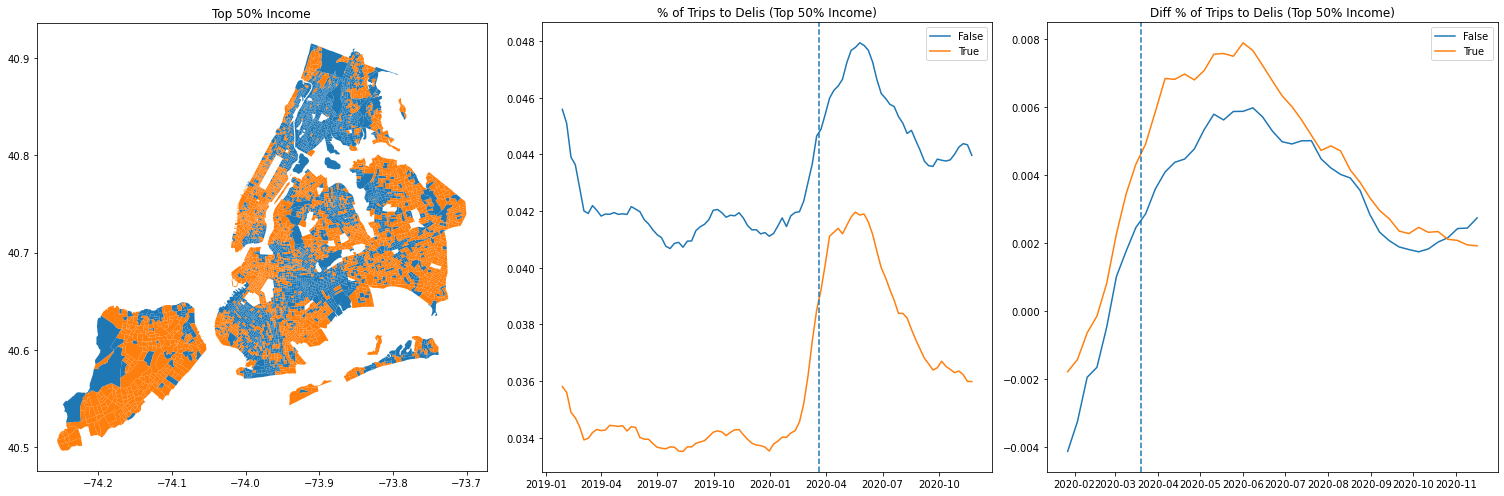

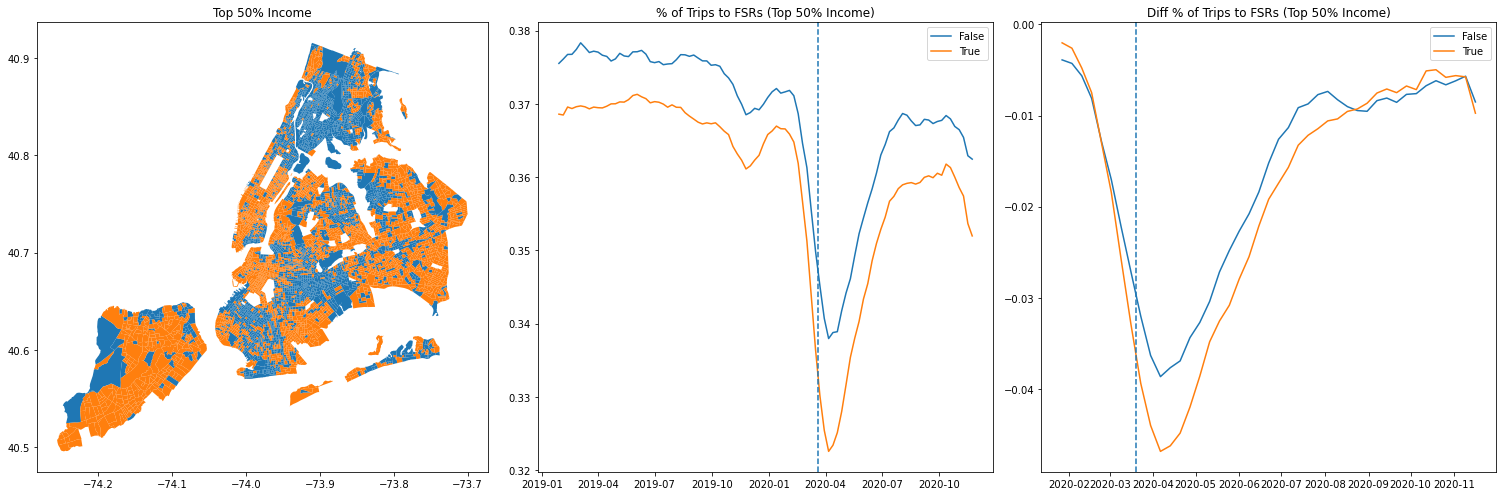

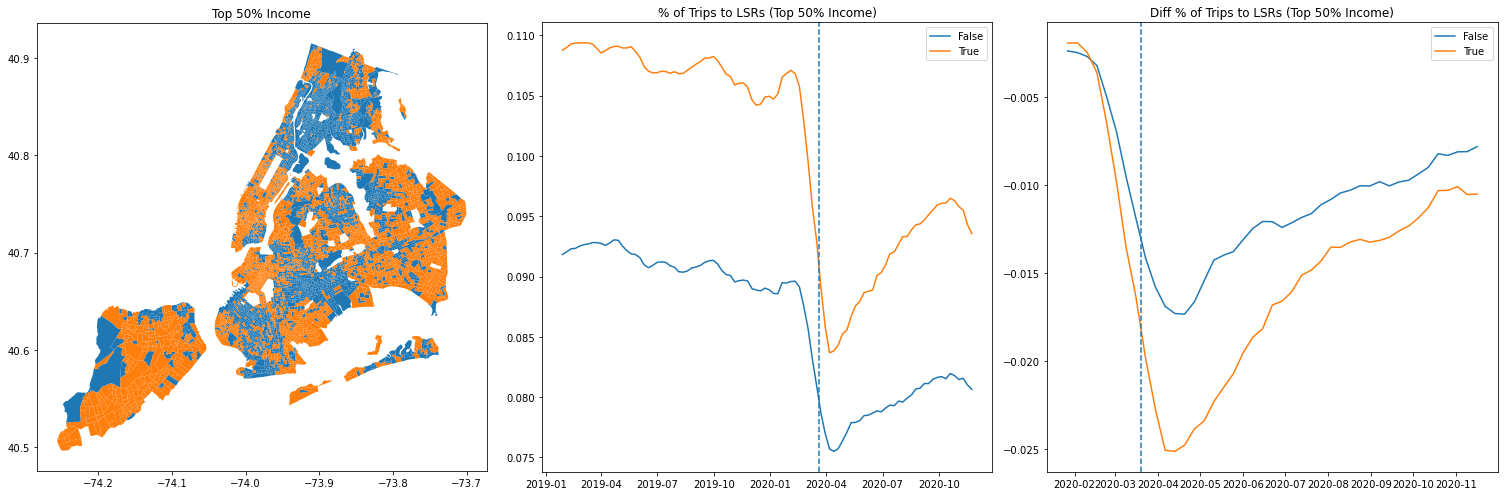

In [16]:
# Use NYC median income not median of CBG median income.
median_index = 63998
cbg_gdf['is_high_income'] = cbg_gdf['income'] > median_index
cbg_gdf['color_is_high_income'] = 'C' + cbg_gdf['is_high_income'].astype(int).astype(str)

high_income_df, high_income_diff_df = create_boolean_dfs(cbg_gdf, attr_column='is_high_income')
plot_boolean_dfs(high_income_df, high_income_diff_df, cbg_gdf, attr_column='is_high_income', attr_title='Income')

## Children

has_children  week          date_range_start   pct_ffr   pct_fvm    pct_sm  \
0         False     2 2020-01-06 00:00:00-05:00  0.003697 -0.000144  0.003385   
1          True     2 2020-01-06 00:00:00-05:00  0.006844  0.000314  0.002502   
2         False     3 2020-01-13 00:00:00-05:00  0.003558 -0.000318  0.002107   

   pct_deli   pct_fsr   pct_lsr  
0 -0.002405 -0.000424 -0.002551  
1 -0.004069 -0.003914 -0.001316  
2 -0.005642  0.002864 -0.001868

5


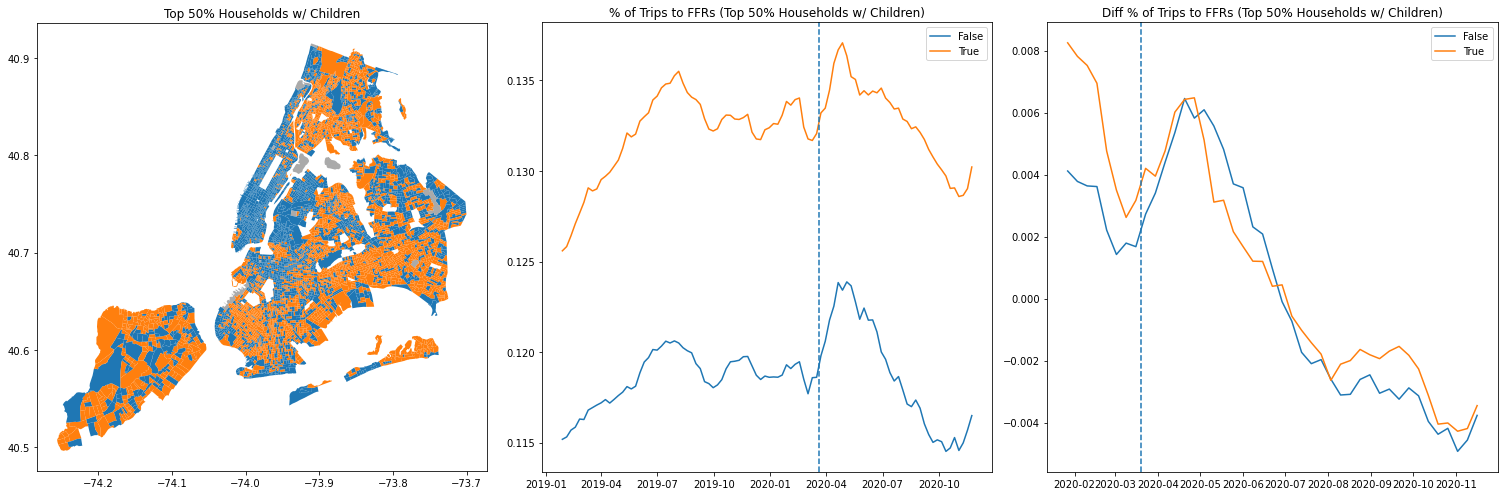

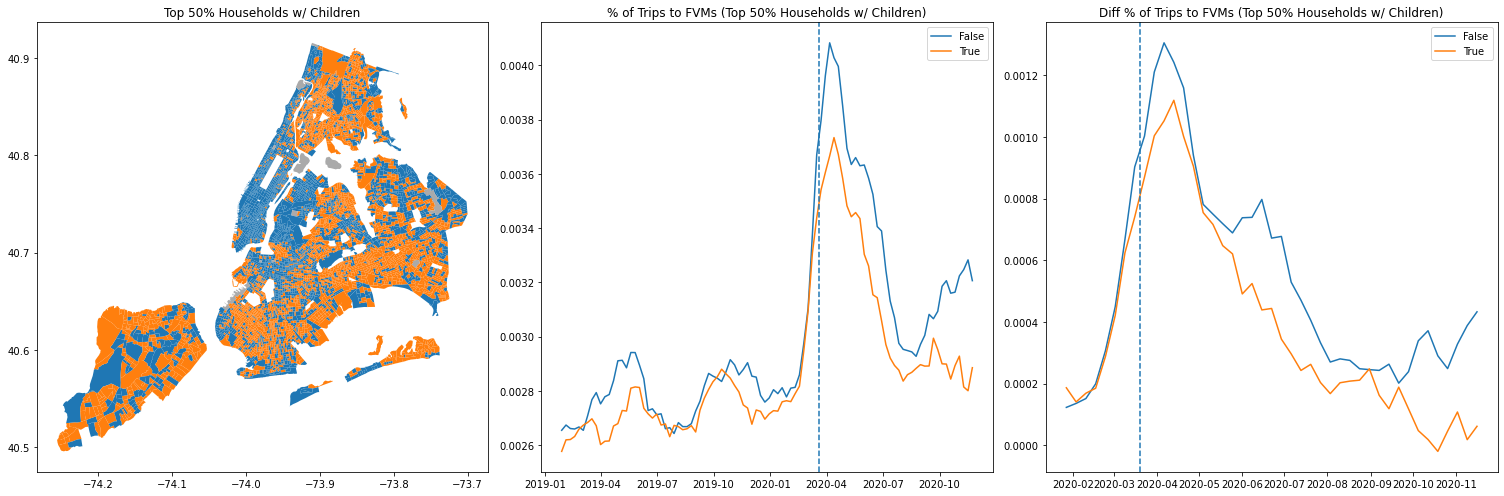

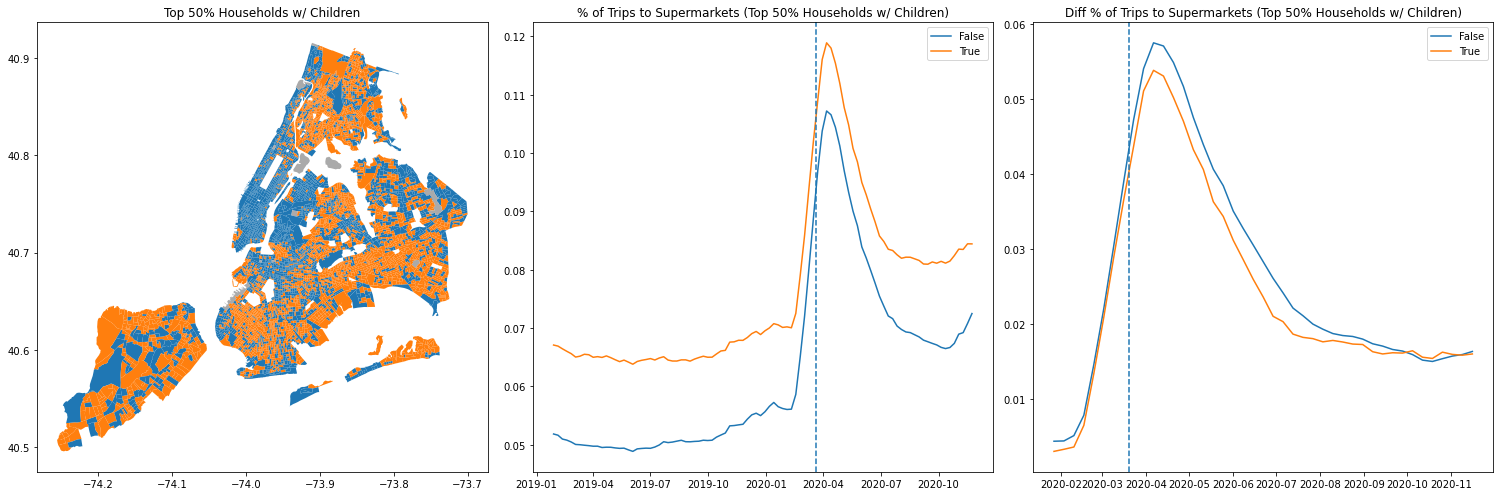

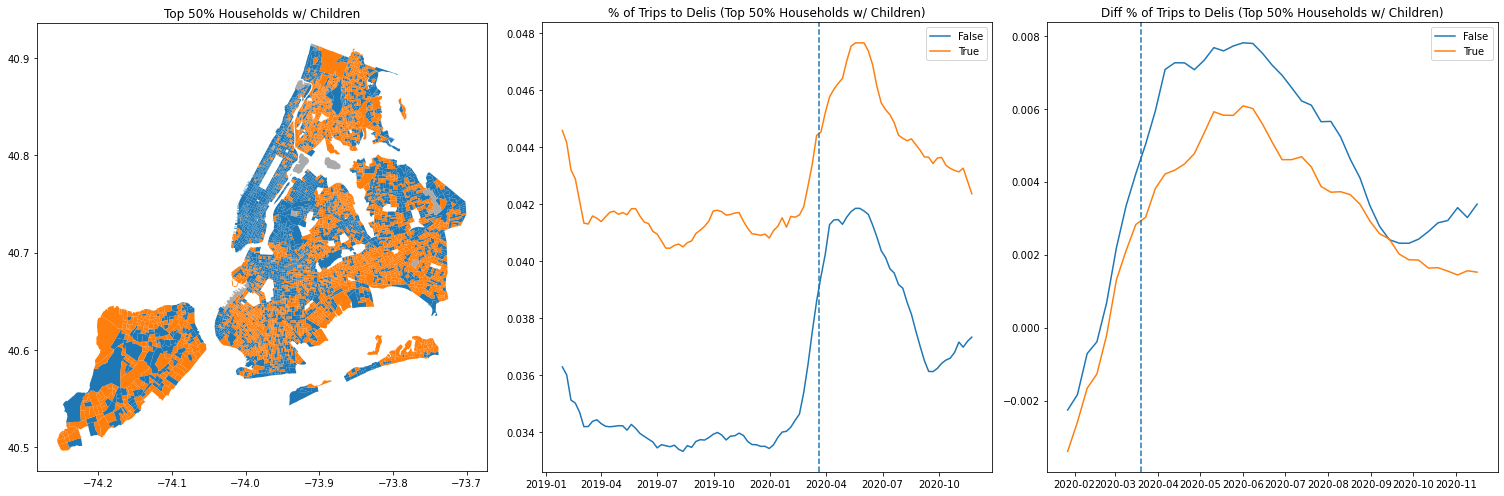

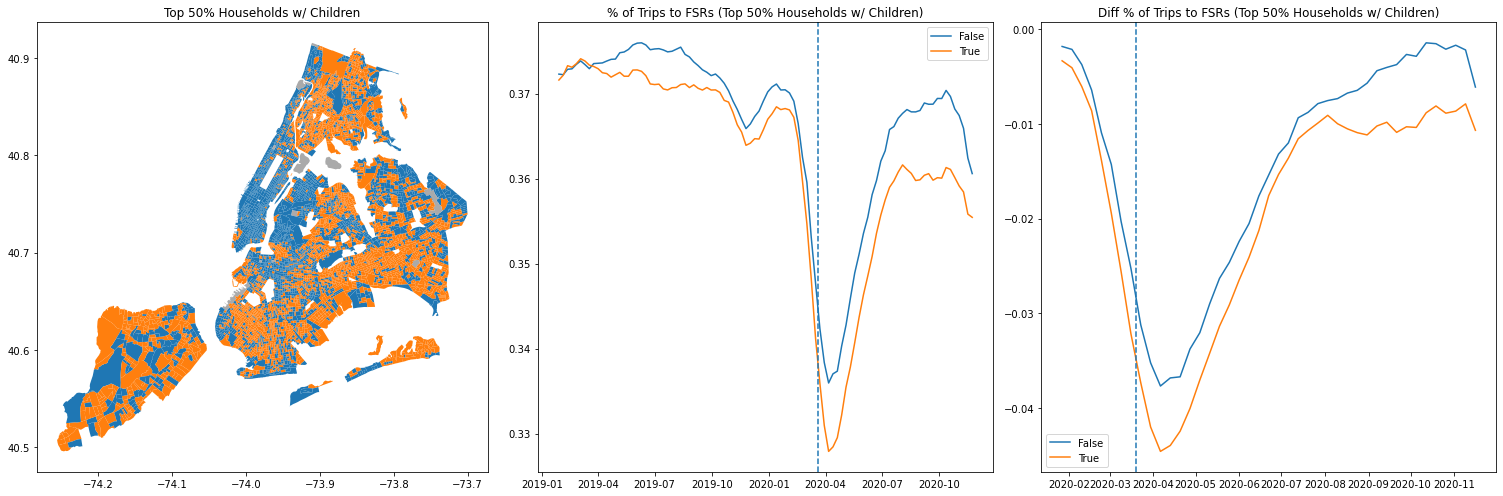

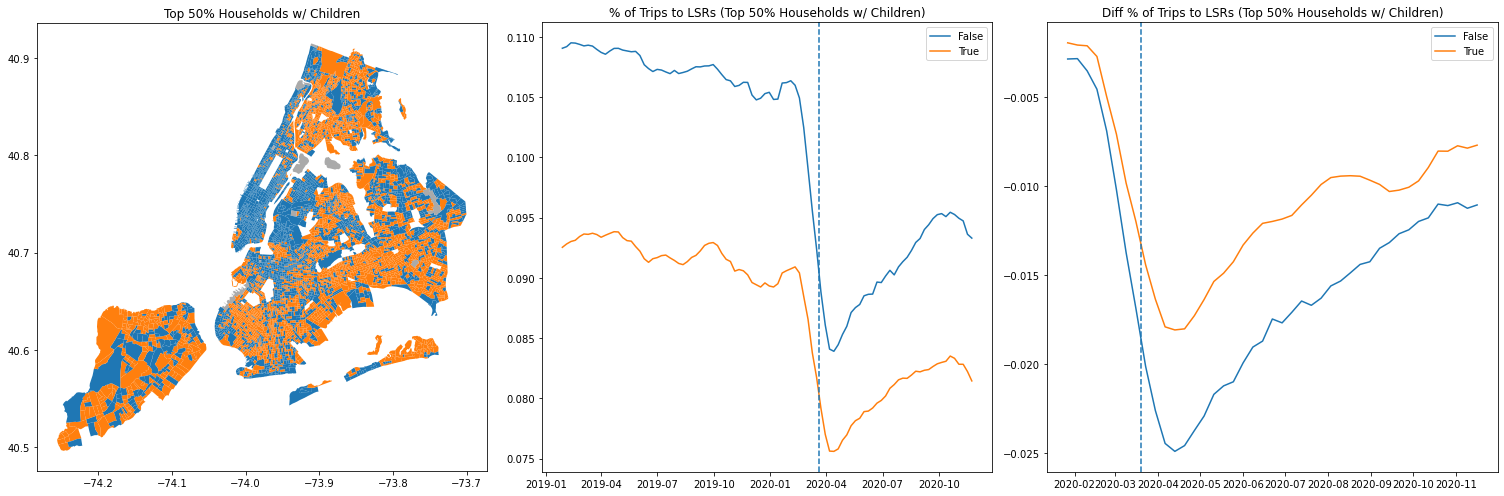

In [17]:
data_indices = cbg_gdf['pct_children'].notna()
median_index = np.median(cbg_gdf[data_indices]['pct_children'])

cbg_gdf['has_children'] = None
cbg_gdf.loc[data_indices, 'has_children'] = cbg_gdf.loc[data_indices, 'pct_children'] > median_index
cbg_gdf['color_has_children'] = '#aaa'
cbg_gdf.loc[data_indices, 'color_has_children'] = 'C' + cbg_gdf.loc[data_indices, 'has_children'].astype(int).astype(str)

children_df, children_diff_df = create_boolean_dfs(cbg_gdf, attr_column='has_children')
plot_boolean_dfs(children_df, children_diff_df, cbg_gdf, attr_column='has_children', attr_title='Households w/ Children')

## SNAP

has_snap  week          date_range_start   pct_ffr   pct_fvm    pct_sm  \
0     False     2 2020-01-06 00:00:00-05:00  0.002138  0.000363  0.002797   
1      True     2 2020-01-06 00:00:00-05:00  0.008436 -0.000148  0.002641   
2     False     3 2020-01-13 00:00:00-05:00  0.001949 -0.000043  0.001427   

   pct_deli   pct_fsr   pct_lsr  
0 -0.001250 -0.001419 -0.000622  
1 -0.005603 -0.003081 -0.002419  
2 -0.004214  0.003639 -0.000838

5


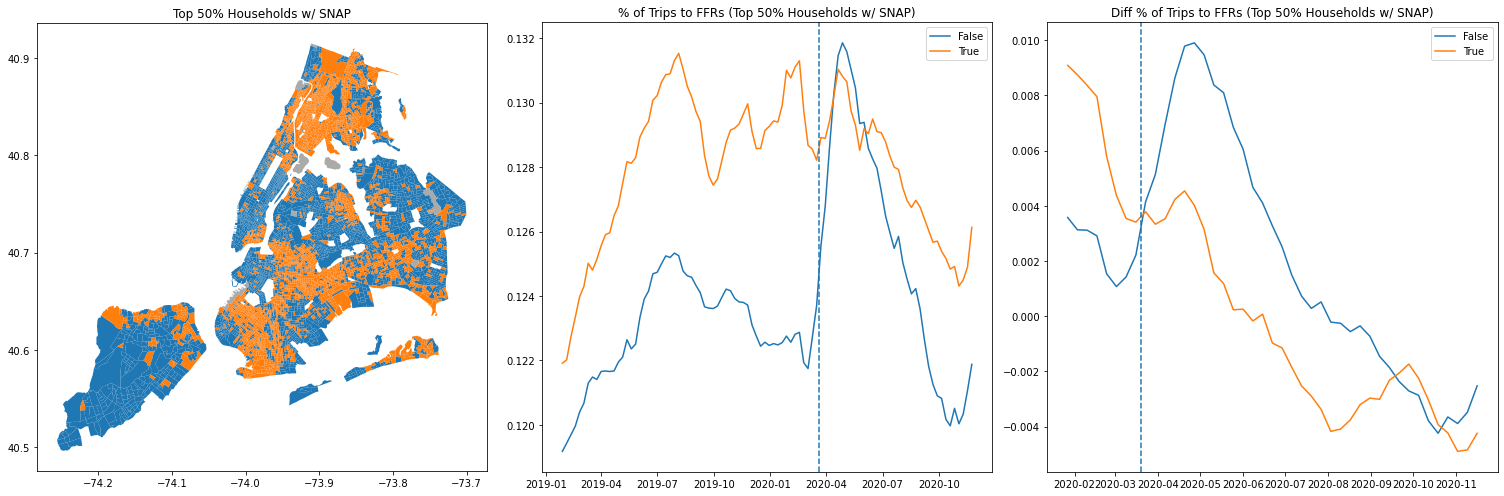

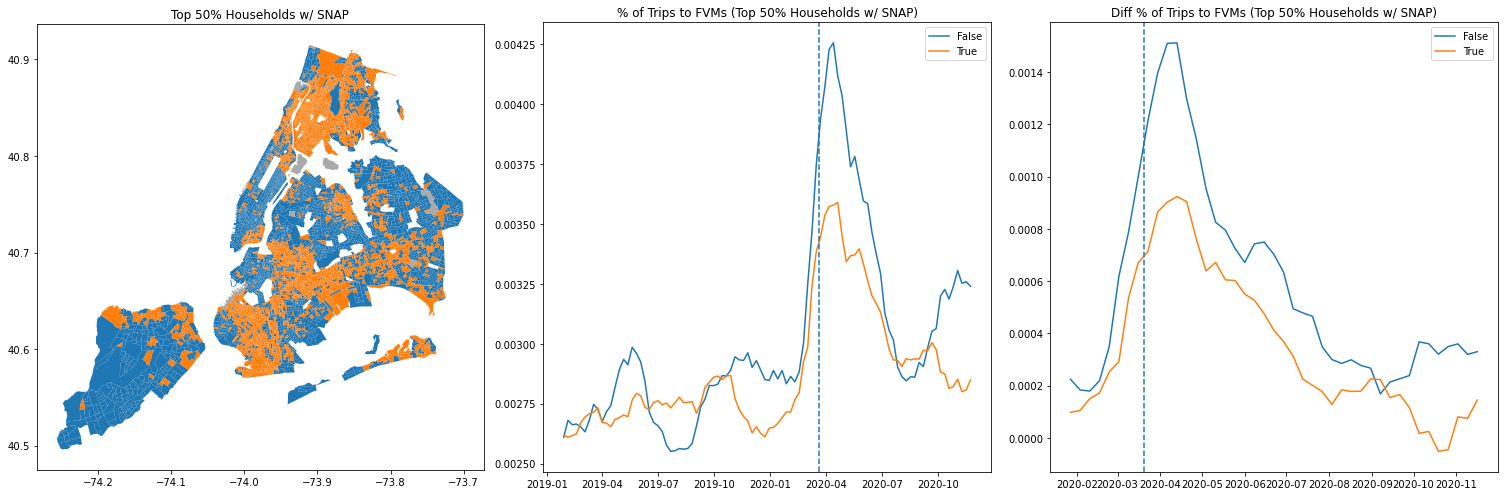

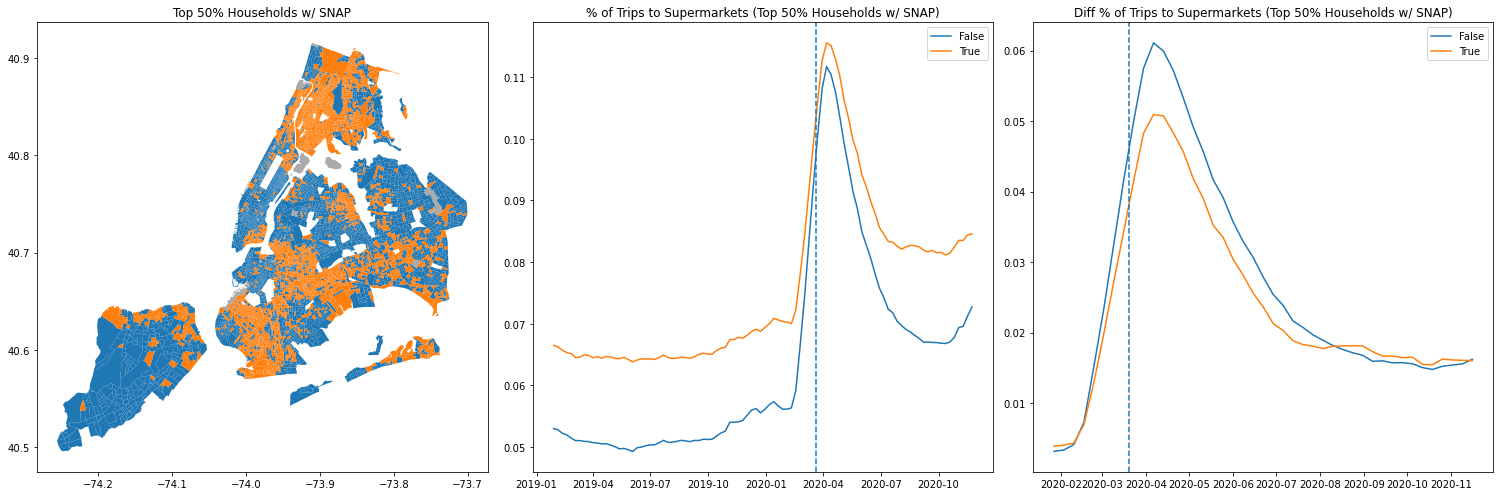

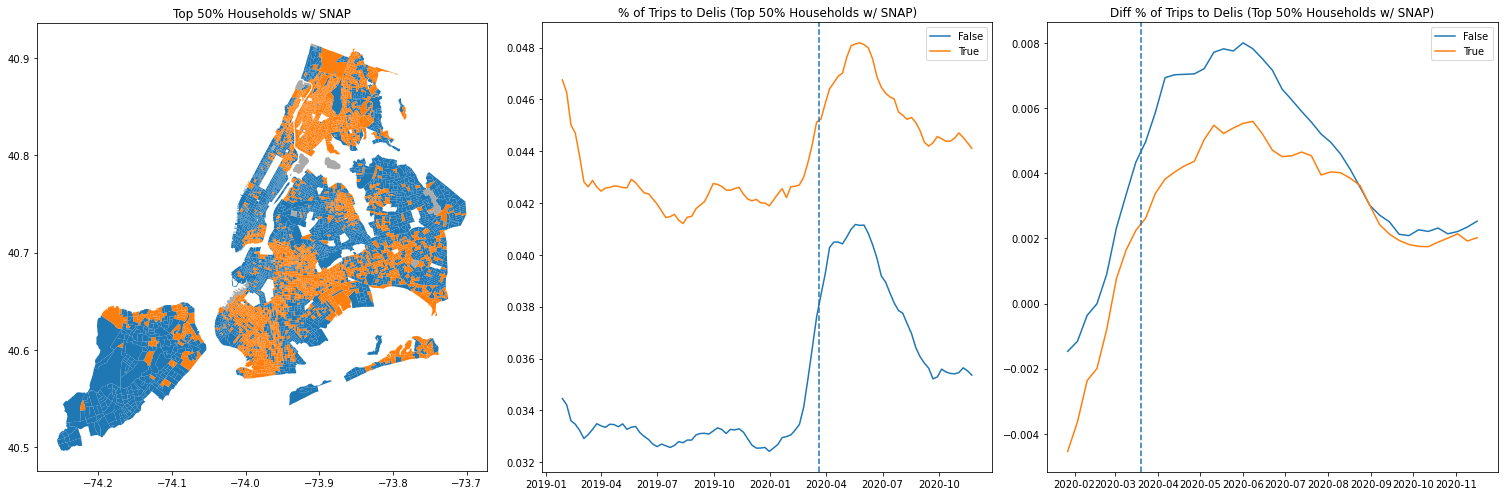

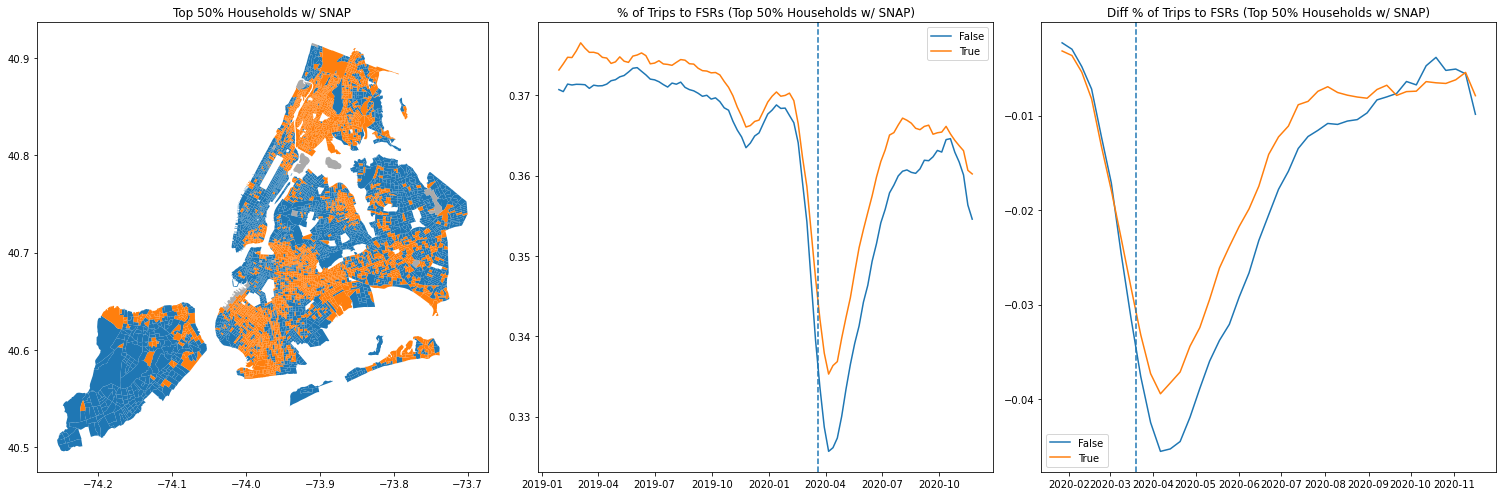

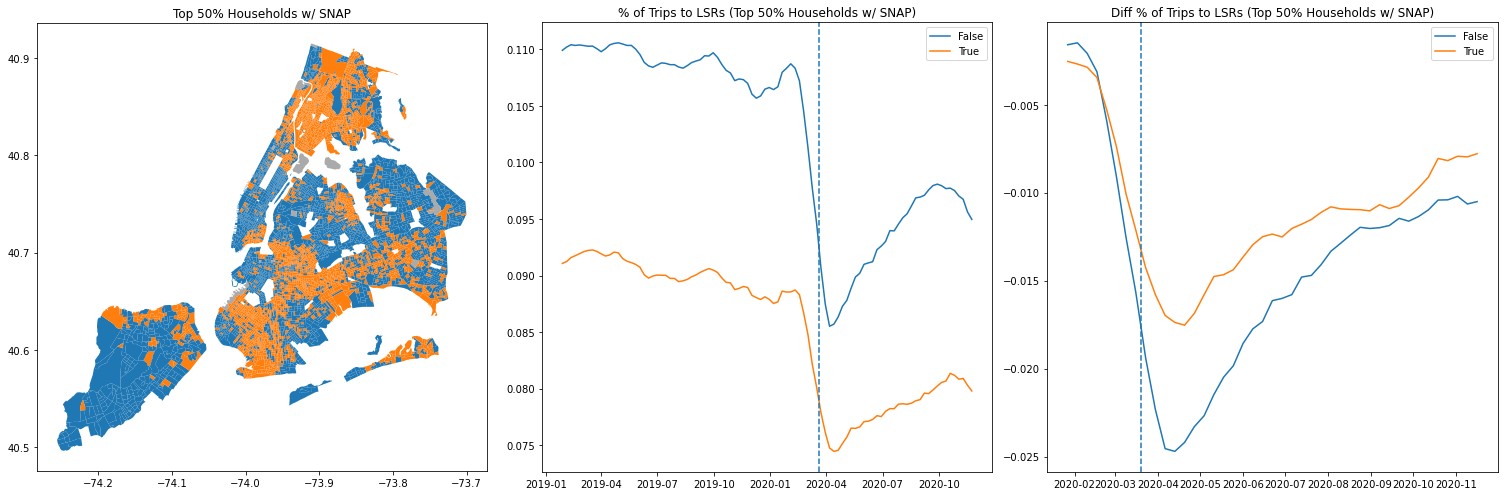

In [18]:
data_indices = cbg_gdf['pct_snap'].notna()
median_index = np.median(cbg_gdf[data_indices]['pct_snap'])

cbg_gdf['has_snap'] = None
cbg_gdf.loc[data_indices, 'has_snap'] = cbg_gdf.loc[data_indices, 'pct_snap'] > median_index
cbg_gdf['color_has_snap'] = '#aaa'
cbg_gdf.loc[data_indices, 'color_has_snap'] = 'C' + cbg_gdf.loc[data_indices, 'has_snap'].astype(int).astype(str)

snap_df, snap_diff_df = create_boolean_dfs(cbg_gdf, attr_column='has_snap')
plot_boolean_dfs(snap_df, snap_diff_df, cbg_gdf, attr_column='has_snap', attr_title='Households w/ SNAP')

## Poverty

has_poverty  week          date_range_start   pct_ffr   pct_fvm    pct_sm  \
0        False     2 2020-01-06 00:00:00-05:00  0.004769  0.000326  0.002373   
1         True     2 2020-01-06 00:00:00-05:00  0.006355 -0.000110  0.003477   
2        False     3 2020-01-13 00:00:00-05:00  0.002769 -0.000037  0.001636   

   pct_deli   pct_fsr   pct_lsr  
0 -0.000971 -0.002345 -0.001909  
1 -0.005573 -0.002248 -0.001866  
2 -0.004995  0.004091 -0.001548

5


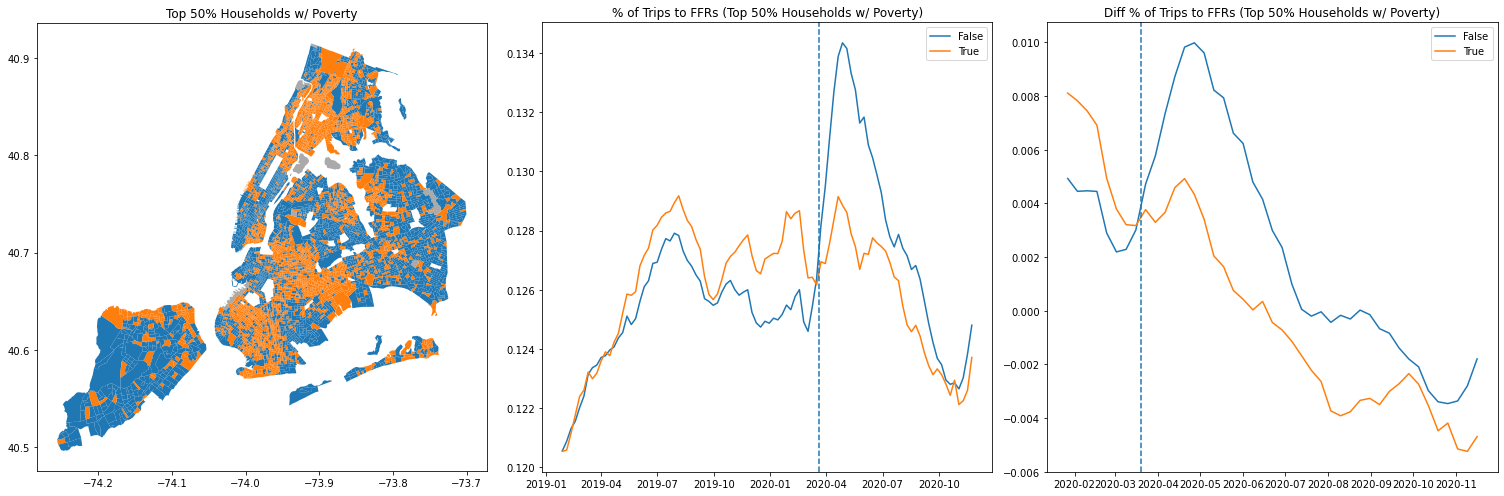

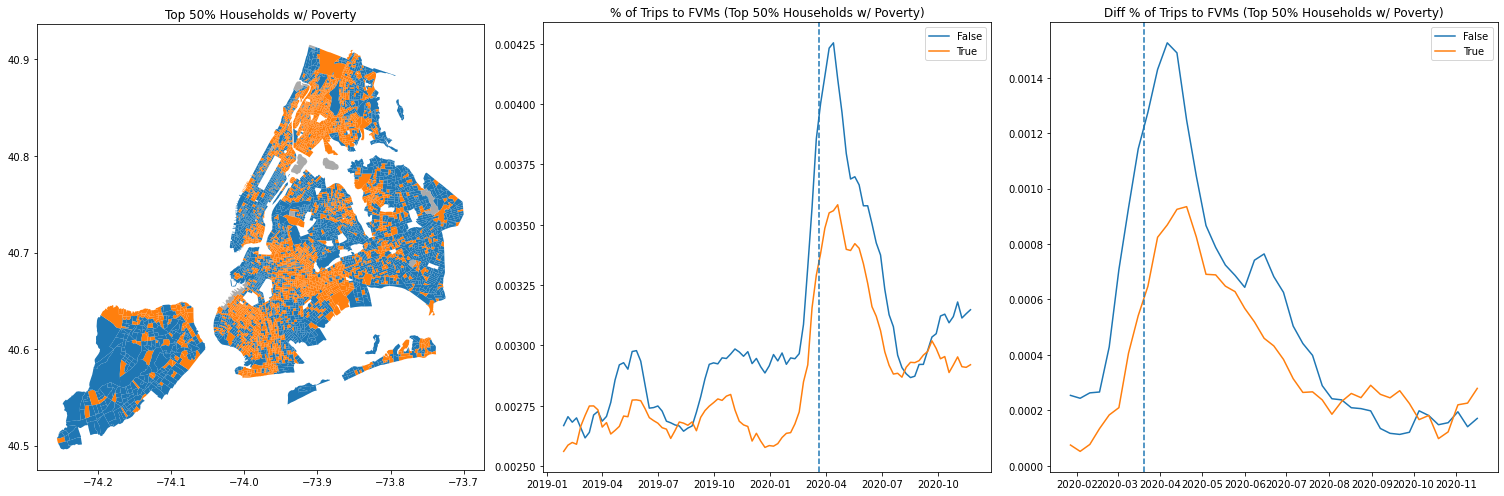

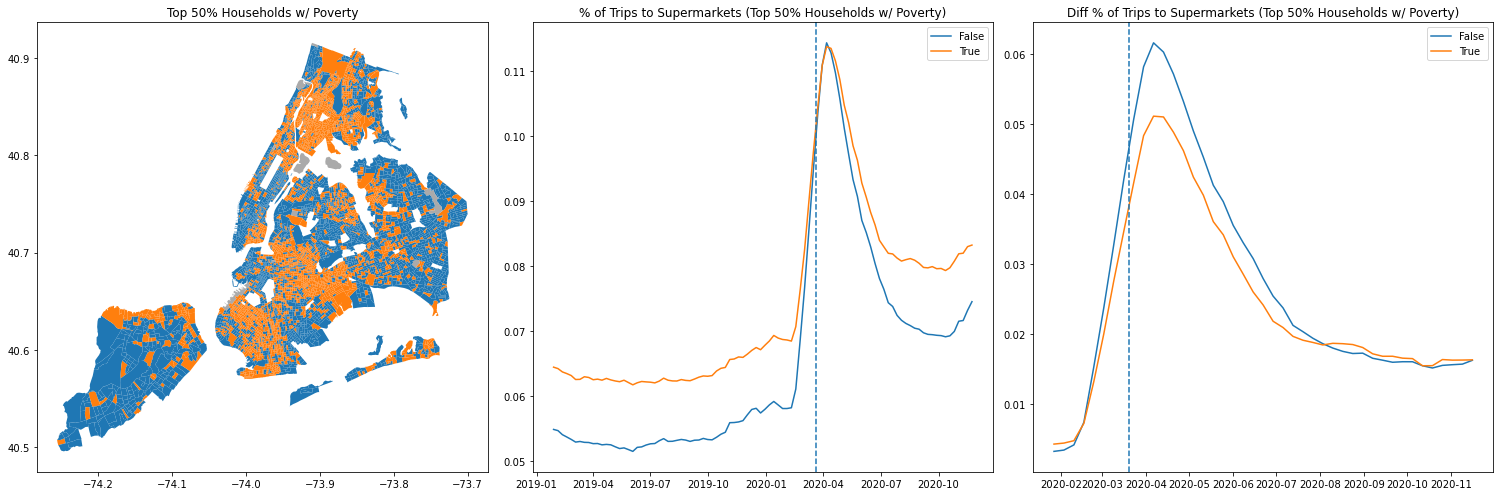

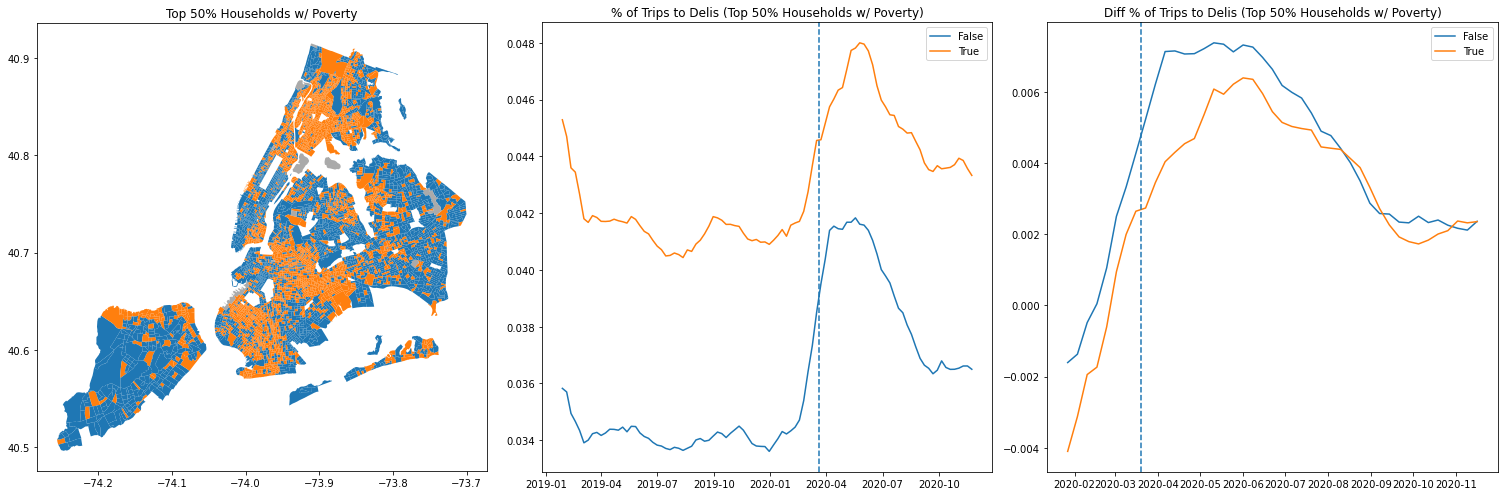

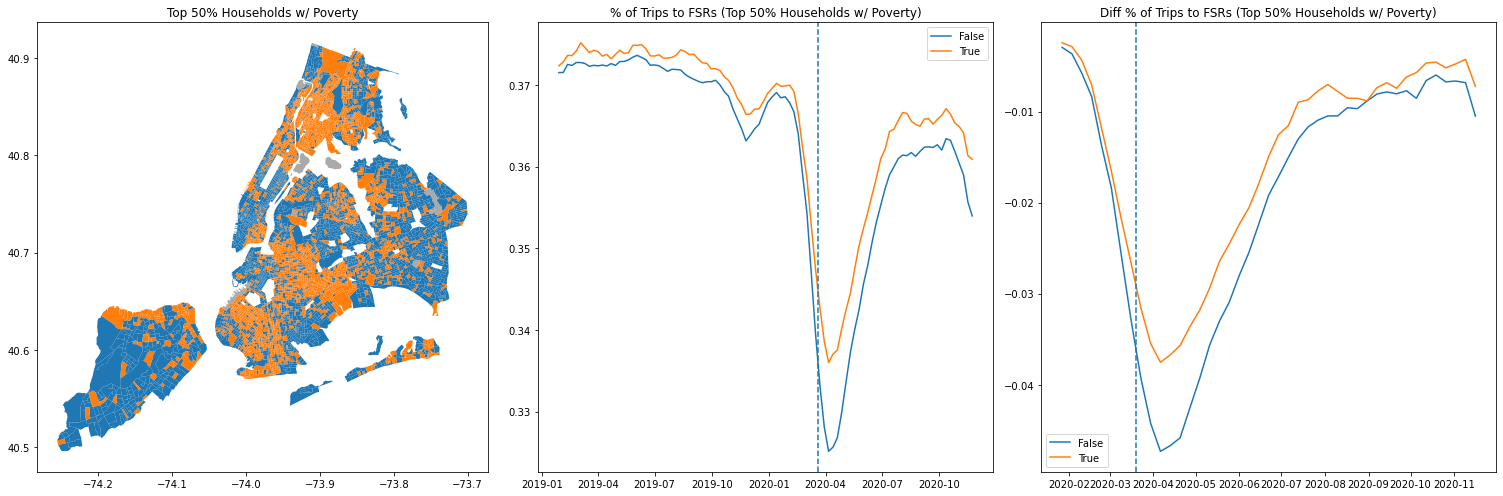

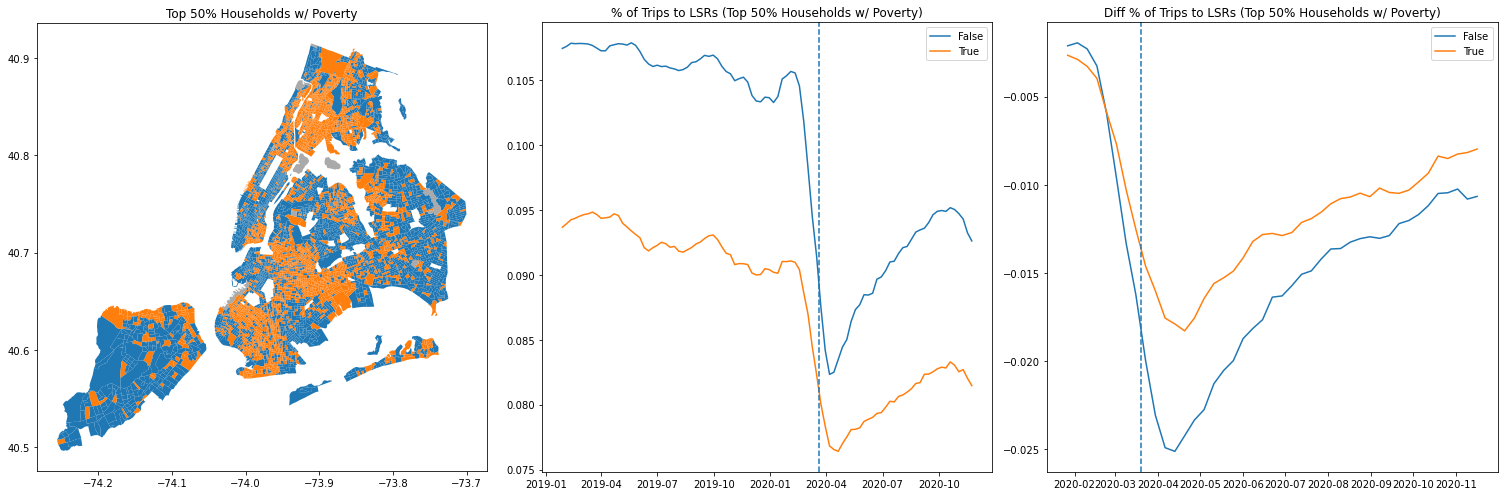

In [19]:
data_indices = cbg_gdf['pct_poverty'].notna()
median_index = np.median(cbg_gdf[data_indices]['pct_poverty'])

cbg_gdf['has_poverty'] = None
cbg_gdf.loc[data_indices, 'has_poverty'] = cbg_gdf.loc[data_indices, 'pct_poverty'] > median_index
cbg_gdf['color_has_poverty'] = '#aaa'
cbg_gdf.loc[data_indices, 'color_has_poverty'] = 'C' + cbg_gdf.loc[data_indices, 'has_poverty'].astype(int).astype(str)

poverty_df, poverty_diff_df = create_boolean_dfs(cbg_gdf, attr_column='has_poverty')
plot_boolean_dfs(poverty_df, poverty_diff_df, cbg_gdf, attr_column='has_poverty', attr_title='Households w/ Poverty')

In [20]:
# Children
# Driving

# Archived work

In [21]:
trips_df = home_df.groupby(by=['date_range_start']).agg({
    'estimated_visitor_count': 'sum',
    'estimated_ffr_visitor_count': 'sum',
}).reset_index()
trips_df['pct_ffr'] = trips_df['estimated_ffr_visitor_count'] / trips_df[
    'estimated_visitor_count']
peek(trips_df)

date_range_start  estimated_visitor_count  \
0 2019-01-07 00:00:00-05:00             3.003713e+06   
1 2019-01-14 00:00:00-05:00             3.031450e+06   
2 2019-01-21 00:00:00-05:00             2.963663e+06   

   estimated_ffr_visitor_count   pct_ffr  
0                363457.942972  0.121003  
1                365245.297699  0.120485  
2                355873.171100  0.120079

102


In [22]:
trips_diff_df = create_diff_df(trips_df, diff_columns=['pct_ffr'])
trips_diff_df = smoothen(trips_diff_df, columns=['pct_ffr'])

week          date_range_start   pct_ffr
0     2 2020-01-06 00:00:00-05:00  0.005806
1     3 2020-01-13 00:00:00-05:00  0.006102
2     4 2020-01-20 00:00:00-05:00  0.006516

5


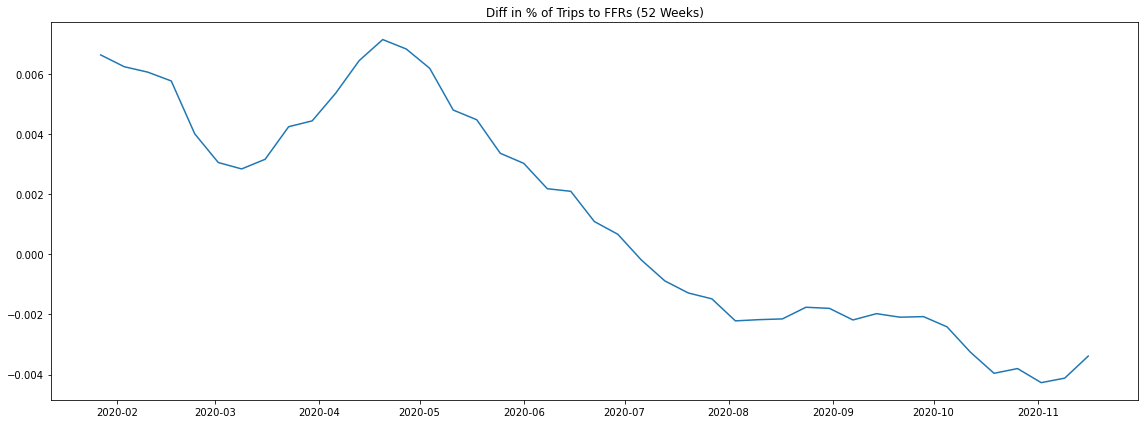

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(trips_diff_df['date_range_start'],
        trips_diff_df['pct_ffr'],
        color='C0')
ax.set_title('Diff in % of Trips to FFRs (52 Weeks)')
plt.tight_layout()
plt.show()

NameError: name 'near_ffr_df' is not defined

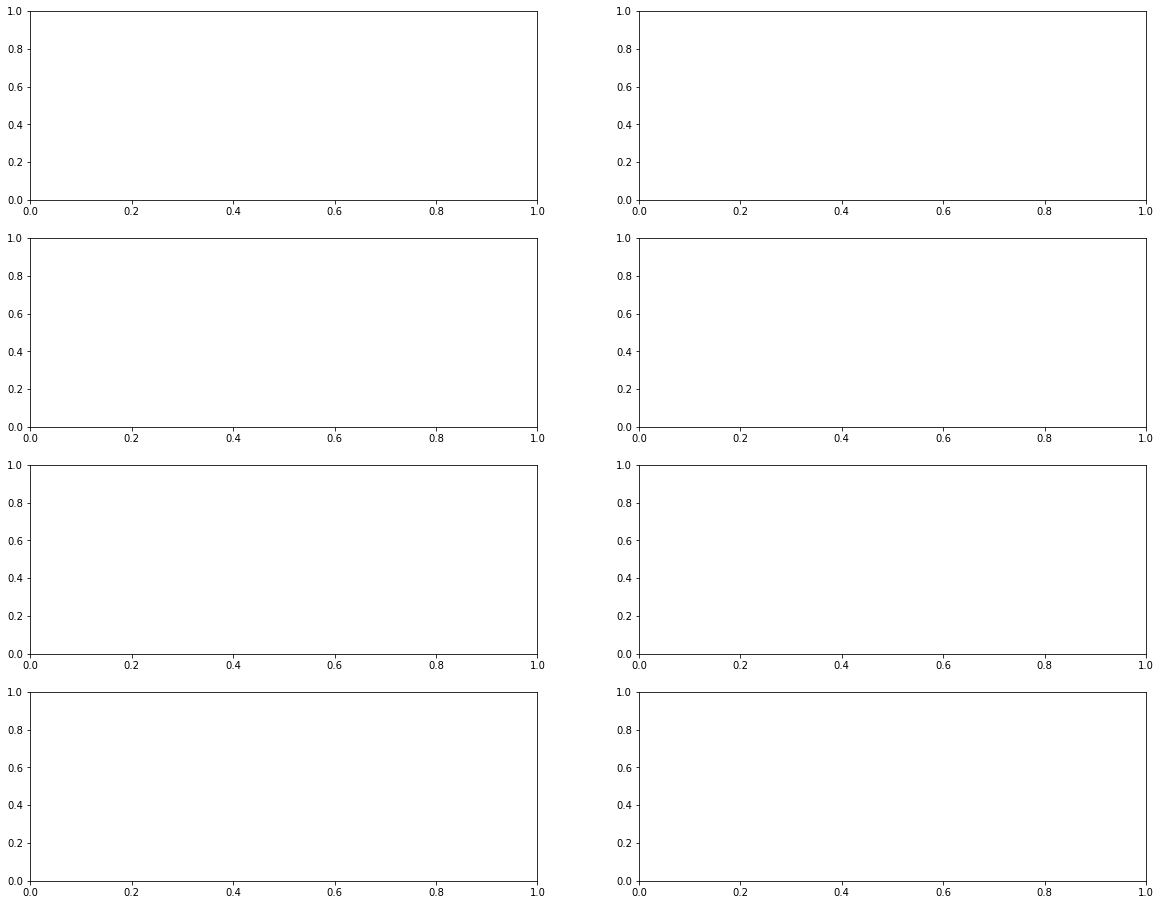

In [24]:
fig, ax = plt.subplots(4, 2, figsize=(20, 16))

for key, group in near_ffr_df.groupby(by=['near_ffr']):
    ax[0, 0].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[0, 0].set_title('% of Trips to FFRs (Top 50% FFR Proximity)')

for key, group in near_ffr_diff_df.groupby(by=['near_ffr']):
    ax[0, 1].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[0, 1].set_title('Diff % of Trips to FFRs (Top 50% FFR Proximity)')

for key, group in near_ssfs_df.groupby(by=['near_ssfs']):
    ax[1, 0].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[1, 0].set_title('% of Trips to FFRs (Top 50% SSFS Proximity)')

for key, group in near_ssfs_diff_df.groupby(by=['near_ssfs']):
    ax[1, 1].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[1, 1].set_title('Diff % of Trips to FFRs (Top 50% SSFS Proximity)')

for key, group in near_ffr_only_df.groupby(by=['near_ffr_only']):
    ax[2, 0].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[2, 0].set_title('% of Trips to FFRs (Top 50% FFR Bottom 50% SSFS Proximity)')

for key, group in near_ffr_only_diff_df.groupby(by=['near_ffr_only']):
    ax[2, 1].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[2, 1].set_title(
    'Diff % of Trips to FFRs (Top 50% FFR Bottom 50% SSFS Proximity)')

for key, group in near_ssfs_only_df.groupby(by=['near_ssfs_only']):
    ax[3, 0].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[3, 0].set_title('% of Trips to FFRs (Bottom 50% FFR Top 50% SSFS Proximity)')

for key, group in near_ssfs_only_diff_df.groupby(by=['near_ssfs_only']):
    ax[3, 1].plot(group['date_range_start'], group['pct_ffr'], label=key)
ax[3, 1].set_title(
    'Diff % of Trips to FFRs (Bottom 50% FFR Top 50% SSFS Proximity)')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[2, 0].legend()
ax[2, 0].legend()
ax[3, 1].legend()
ax[3, 1].legend()

ax[0, 0].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[0, 1].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[1, 0].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[1, 1].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[2, 0].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[2, 1].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[3, 0].axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax[3, 1].axvline(datetime.datetime(2020, 3, 20), linestyle='--')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cbg_gdf.plot(ax=ax[0], color=cbg_gdf['color_ffr'])
cbg_gdf.plot(ax=ax[1], color=cbg_gdf['color_ssfs'])
ax[0].set_title('Top 50% FFR Proximity')
ax[1].set_title('Top 50% SSFS Proximity')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cbg_gdf.plot(ax=ax[0], color=cbg_gdf['color_ffr_only'])
cbg_gdf.plot(ax=ax[1], color=cbg_gdf['color_ssfs_only'])
ax[0].set_title('Top 50% FFR Bottom 50% SSFS Proximity')
ax[1].set_title('Top 50% SSFS Bottom 50% FFR Proximity')
plt.tight_layout()
plt.show()

In [ ]:
cbg_df = pd.read_csv('./exports/proximity_clusters.csv')

In [ ]:
cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({
    'estimated_visitor_count': 'sum',
    'estimated_ffr_visitor_count': 'sum',
}).reset_index()
cluster_df = cluster_df.sort_values(by=['date_range_start', 'cluster'])
cluster_df['pct_ffr'] = cluster_df['estimated_ffr_visitor_count'] / cluster_df[
    'estimated_visitor_count']
cluster_df = smoothen_within(cluster_df, columns=['pct_ffr'], by='cluster')
peek(cluster_df)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['pct_ffr'], label=key)
ax.set_title('% of Trips to FFRs')
ax.axvline(datetime.datetime(2020, 3, 20), linestyle='--')
ax.legend()
plt.show()

In [ ]:
proximity_df = pd.read_csv('./exports/proximity_count_index_sampled.csv')
peek(proximity_df)

In [ ]:
median_index = np.median(proximity_df['category_0_proximity_index'])
proximity_df['near_ffr'] = proximity_df['category_0_proximity_index'] > median_index
median_index = np.median(proximity_df['category_1_proximity_index'])
proximity_df['near_ssfs'] = proximity_df['category_1_proximity_index'] > median_index
proximity_df['near_ffr_only'] = (~proximity_df['near_ssfs'] & proximity_df['near_ffr'])
proximity_df['near_ssfs_only'] = (proximity_df['near_ssfs'] & ~proximity_df['near_ffr'])
peek(proximity_df)

In [ ]:
merge_proximity_df = merge_df.merge(proximity_df, how='inner', on=['cbg'])
peek(merge_proximity_df)

In [ ]:
near_ffr_df = merge_proximity_df.groupby(
    by=['date_range_start', 'near_ffr']).agg({
        'estimated_visitor_count': 'sum',
        'estimated_ffr_visitor_count': 'sum',
    }).reset_index()
near_ffr_df['pct_ffr'] = near_ffr_df[
    'estimated_ffr_visitor_count'] / near_ffr_df['estimated_visitor_count']
near_ffr_diff_df = create_diff_df(near_ffr_df,
                                  diff_columns=['pct_ffr'],
                                  keep_columns=['near_ffr'])
near_ffr_df = smoothen_within(near_ffr_df, columns=['pct_ffr'], by='near_ffr')
near_ffr_diff_df = smoothen_within(near_ffr_diff_df,
                                   columns=['pct_ffr'],
                                   by='near_ffr')

In [ ]:
near_ffr_only_df = merge_proximity_df.groupby(
    by=['date_range_start', 'near_ffr_only']).agg({
        'estimated_visitor_count': 'sum',
        'estimated_ffr_visitor_count': 'sum',
    }).reset_index()
near_ffr_only_df['pct_ffr'] = near_ffr_only_df[
    'estimated_ffr_visitor_count'] / near_ffr_only_df['estimated_visitor_count']
near_ffr_only_diff_df = create_diff_df(near_ffr_only_df,
                                       diff_columns=['pct_ffr'],
                                       keep_columns=['near_ffr_only'])
near_ffr_only_df = smoothen_within(near_ffr_only_df,
                                   columns=['pct_ffr'],
                                   by='near_ffr_only')
near_ffr_only_diff_df = smoothen_within(near_ffr_only_diff_df,
                                        columns=['pct_ffr'],
                                        by='near_ffr_only')

In [ ]:
near_ssfs_df = merge_proximity_df.groupby(
    by=['date_range_start', 'near_ssfs']).agg({
        'estimated_visitor_count': 'sum',
        'estimated_ffr_visitor_count': 'sum',
    }).reset_index()
near_ssfs_df['pct_ffr'] = near_ssfs_df[
    'estimated_ffr_visitor_count'] / near_ssfs_df['estimated_visitor_count']
near_ssfs_diff_df = create_diff_df(near_ssfs_df,
                                       diff_columns=['pct_ffr'],
                                       keep_columns=['near_ssfs'])
near_ssfs_df = smoothen_within(near_ssfs_df,
                                   columns=['pct_ffr'],
                                   by='near_ssfs')
near_ssfs_diff_df = smoothen_within(near_ssfs_diff_df,
                                        columns=['pct_ffr'],
                                        by='near_ssfs')

In [ ]:
near_ssfs_only_df = merge_proximity_df.groupby(
    by=['date_range_start', 'near_ssfs_only']).agg({
        'estimated_visitor_count': 'sum',
        'estimated_ffr_visitor_count': 'sum',
    }).reset_index()
near_ssfs_only_df['pct_ffr'] = near_ssfs_only_df[
    'estimated_ffr_visitor_count'] / near_ssfs_only_df['estimated_visitor_count']
near_ssfs_only_diff_df = create_diff_df(near_ssfs_only_df,
                                       diff_columns=['pct_ffr'],
                                       keep_columns=['near_ssfs_only'])
near_ssfs_only_df = smoothen_within(near_ssfs_only_df,
                                   columns=['pct_ffr'],
                                   by='near_ssfs_only')
near_ssfs_only_diff_df = smoothen_within(near_ssfs_only_diff_df,
                                        columns=['pct_ffr'],
                                        by='near_ssfs_only')